In [25]:
import warnings
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


from torchinfo import summary

# 데이터 경로 설정

In [8]:
data_dir = '/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data'

print(os.getcwd())

/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog


# 초기 이미지 개수 확인

In [ ]:
subfolders = ['test_set', 'training_set']

total_file_counter = 0

for subfolder in subfolders:
    folder_path = os.path.join(data_dir, subfolder)
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += sum(1 for file in files if file.lower().endswith('.jpg'))
    print(f"{subfolder} 폴더 내 JPG 파일 수: {count}개")
    total_file_counter += count

print(f'총 파일 개수: {total_file_counter}개')

test_set 폴더 내 JPG 파일 수: 2023개
training_set 폴더 내 JPG 파일 수: 8005개
총 파일 개수: 10028개


# 이미지 파일 추출

In [18]:
from os.path import dirname
paths = []
data_sets = []
labels = []

def load_images(base_dir):
    images = []
    for root, _, files in os.walk(base_dir):
        for file_name in files:
            if file_name.lower().endswith('.jpg'):
                file_path = os.path.join(root, file_name)
                paths.append(file_path)

                # 이미지 로딩 및 색상 변환
                img = cv2.imread(file_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)

                # 상대 경로 파싱 (ex: training_set/cats/...)
                rel_path = os.path.relpath(file_path, base_dir)
                path_parts = rel_path.split(os.path.sep)

                if len(path_parts) >= 3:
                    # 1. "training_set" → "training", "test_set" → "test"
                    dataset_type = path_parts[0].replace('_set', '')   # 정확히 '_set'만 제거

                    # 2. "cats" → "cat", "dogs" → "dog"
                    label_type = path_parts[1][:-1]  # 's'만 제거 (cat/dog)

                    data_set_label = f"{dataset_type}_{label_type}"
                    data_sets.append(data_set_label)

                    # label도 동일하게 구성
                    labels.append(data_set_label)
                else:
                    data_sets.append('N/A')
                    labels.append('N/A')

    return images

In [19]:
images = load_images(data_dir)

In [20]:
print(set(data_sets))
# → {'training_cat', 'training_dog', 'test_cat', 'test_dog'}

print(set(labels))
# → {'training_cat', 'training_dog', 'test_cat', 'test_dog'}


{'training_dog', 'training_cat', 'test_dog', 'test_cat'}
{'training_dog', 'training_cat', 'test_dog', 'test_cat'}


In [21]:
print(len(paths))
print(len(data_sets))
print(len(labels))

10028
10028
10028


In [22]:
pd.set_option('display.max_colwidth', 400)

df = pd.DataFrame({
    'path': paths,
    'dataset': data_sets,
    'label': labels
})

print('data_df shape:', df.shape)

df

data_df shape: (10028, 3)


,path,dataset,label
0,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.1753.jpg,training_dog,training_dog
1,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.3144.jpg,training_dog,training_dog
2,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.775.jpg,training_dog,training_dog
3,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.3622.jpg,training_dog,training_dog
4,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/training_set/dogs/dog.1035.jpg,training_dog,training_dog
...,...,...,...
10023,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/test_set/cats/cat.4358.jpg,test_cat,test_cat
10024,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/test_set/cats/cat.4364.jpg,test_cat,test_cat
10025,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/test_set/cats/cat.4402.jpg,test_cat,test_cat
10026,/Users/carki/Desktop/Dev/AI/DL/이미지 분류/Cat_Dog/data/test_set/cats/cat.4416.jpg,test_cat,test_cat


In [23]:
df['dataset'].value_counts()

dataset
training_dog    4005
training_cat    4000
test_dog        1012
test_cat        1011
Name: count, dtype: int64

# 데이터 셋

In [52]:
class CustomPairDataSet(Dataset):
    def __init__(self, train_cat_dir, train_dog_dir, transform=None):
        self.train_cat_dir = train_cat_dir
        self.train_dog_dir = train_dog_dir
        self.transform = transform

        # 개수 맞추기
        self.length = min(len(train_cat_dir), len(train_dog_dir))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        train_cat_path = self.train_cat_dir[idx]
        train_dog_path = self.train_dog_dir[idx]

        # 고양이 이미지
        train_cat_pil_image =  Image.open(self.train_cat_dir[idx]).convert('RGB')
        # 강아지 이미지
        train_dog_pil_image =  Image.open(self.train_dog_dir[idx]).convert('RGB')

        if self.transform:
            train_cat_pil_image = self.transform(train_cat_pil_image)
            train_dog_pil_image = self.transform(train_dog_pil_image)

        # return train_cat_pil_image, train_dog_pil_image
        return train_cat_pil_image, train_dog_pil_image, train_cat_path, train_dog_path

# 데이터 셋 생성

## 이미지 전처리

In [53]:
# # 2. 전처리: AlexNet은 ImageNet 기준으로 학습되었으므로, 해당 전처리 과정을 사용합니다.
# preprocess = transforms.Compose([
#     transforms.Resize(256),               # 짧은 변을 256픽셀로 조정
#     transforms.CenterCrop(224),           # 정중앙에서 224x224 크롭
#     transforms.ToTensor(),                # 텐서 변환
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 평균
#                          std=[0.229, 0.224, 0.225])   # ImageNet 표준편차
# ])

preprocess = transforms.Compose([
    transforms.Resize(256),  # 짧은 변을 256으로
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [54]:
BATCH_SIZE = 16

# 데이터셋 생성
train_pair_dataset = CustomPairDataSet(
    df[df['label']=='training_cat']['path'].tolist(),
    df[df['label']=='training_dog']['path'].tolist(),
    transform=preprocess
)

# DataLoader 생성
train_pair_data_loader = DataLoader(train_pair_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [49]:
train_pair_dataset

## 이미지 시각화

In [58]:
IMG_MEANS = [0.485, 0.456, 0.406],
IMG_STD = [0.229, 0.224, 0.225]

def show_images(loader, num_images=5):
    def denormalize(img_tensor):
        img = img_tensor.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
        if IMG_MEANS and IMG_STD:
            img = img * np.array(IMG_STD) + np.array(IMG_MEANS)
        return np.clip(img, 0, 1)

    for cat_image, dog_image, cat_paths, dog_paths in loader:
        fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 3), dpi=100)
        for i in range(num_images):
            axes[i, 0].imshow(denormalize(cat_image[i]))
            axes[i, 0].set_title(f"Cat {i+1}\n{os.path.basename(cat_paths[i])}")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(denormalize(dog_image[i]))
            axes[i, 1].set_title(f"Dog {i+1}\n{os.path.basename(dog_paths[i])}")
            axes[i, 1].axis('off')
        plt.tight_layout()
        plt.show()
        break



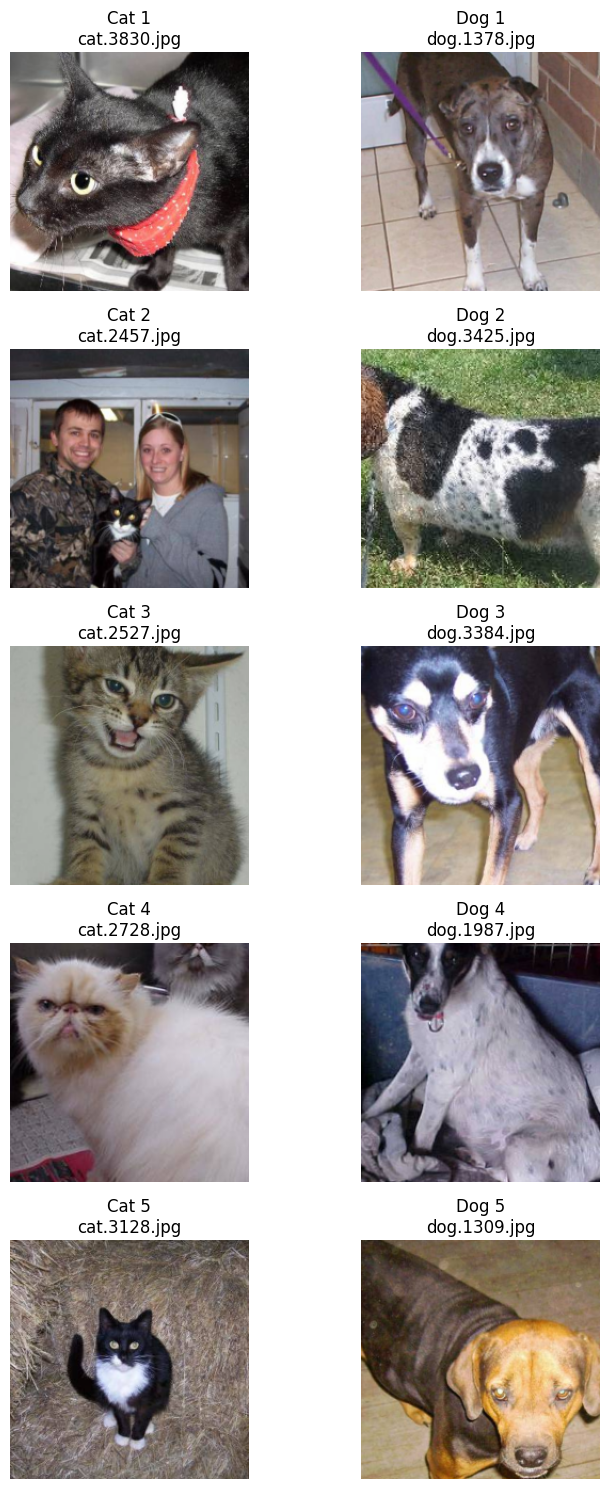

In [57]:
show_images(train_pair_data_loader)

In [4]:
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/carki/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:21<00:00, 11.4MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 